<a href="https://colab.research.google.com/github/Yagwar/Sociadisticas/blob/master/alc_bog_load_JSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

import matplotlib as mpl
mpl.style.use('seaborn-talk')
%matplotlib inline

In [60]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = 'gdrive/My Drive/Freelancer/alc_bog_19/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cuentas=["ClaudiaLopez","carlosfgalan","angelamrobledo","MiguelUribeT","angelagarzonc",
         "luchogarzon","hollmanmorris","MAndreaNieto","CelioNievesH","jerojasrodrigue",
         "LuisErnestoGL"]
ids_cands=["137908875","64791701","165748292","163341528","325856294",
           "60161414","87266285","999594384","240409671","233001872",
           "2499219806"]

# Loader

In [0]:
#get users and mentions from the download files:
tweets_datas_path = [drive_path+"candidatos_alcaldia_0.json",
                     drive_path+"candidatos_alcaldia_1.json",
                     drive_path+"candidatos_alcaldia_2.json",
                     drive_path+"candidatos_alcaldia_3.json"]
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]
tw_device=[]# print(twits[rnd_ind]["source"])
tw_date=[]# print(twits[rnd_ind]["created_at"])


for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop[0]])
                tw_device.append(tweet["source"])
                tw_date.append(tweet["created_at"])
            except:
                continue

In [63]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n",
      "Tweets con dispositivos registrado  :",len(tw_device),"\n",
      "Tweets con fechas registradas       :",len(tw_date),"\n"
     )

Tweets identificados con código     : 721107 
 Tweets con usuario identificado     : 721107 
 Tweets con nombre de usuario        : 721107 
 Textos de tweets recuperados        : 721107 
 Total de Menciones en los tweets    : 4085193 
 Tweets con menciones identificadas  : 721107 
 Tweets con dispositivos registrado  : 721107 
 Tweets con fechas registradas       : 721107 



In [0]:
tw_device=[dvc[dvc.find(">")+1:dvc.find("<",2)] for dvc in tw_device]
tw_text=np.array(tw_text)

### Tabla de menciones

In [0]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [8]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 33352


In [0]:
# Tabla de ocurrencia de menciones por tuit
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")
# se utiliza el código para evitar conteos por homónimos

In [10]:
id_ments.head()


col_0,count
row_0,
137908875,368815
49849732,113424
163341528,101467
87266285,96358
165748292,80354


In [0]:
top_n=150


In [0]:
ments_ids_top=list(id_ments.index[:top_n])

In [0]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])
mntns_candts=np.array([[cand in tw_mntns[2] for cand in ids_cands]for tw_mntns in mentioned_ids])

In [14]:
print(mntns_top_ocurr.shape)
print(mntns_candts.shape)

(721107, 150)
(721107, 11)


In [0]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [0]:
# twtxt_ids=[txt_id[0] for txt_id in tw_text] # Id del tuit con el texto
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top, index=tw_id)
df_mntns_candts=pd.DataFrame(mntns_candts,columns=cuentas, index=tw_id)

In [17]:
print(df_mntns_top_ocurr.shape)
print(df_mntns_candts.shape)

(721107, 150)
(721107, 11)


In [18]:
tweets_ids=pd.DataFrame({"tw_user_id":tw_user_id,"tw_user":tw_user}, index=tw_id)
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 85845


row_0
Twitter for Android        445797
Twitter for iPhone         154785
Twitter Web App             60951
Twitter Web Client          46969
Twitter for iPad             9671
TweetDeck                    1489
Pypbot                        533
Mobile Web (M2)               312
TweetCaster for Android        68
Facebook                       59
Name: count, dtype: int64

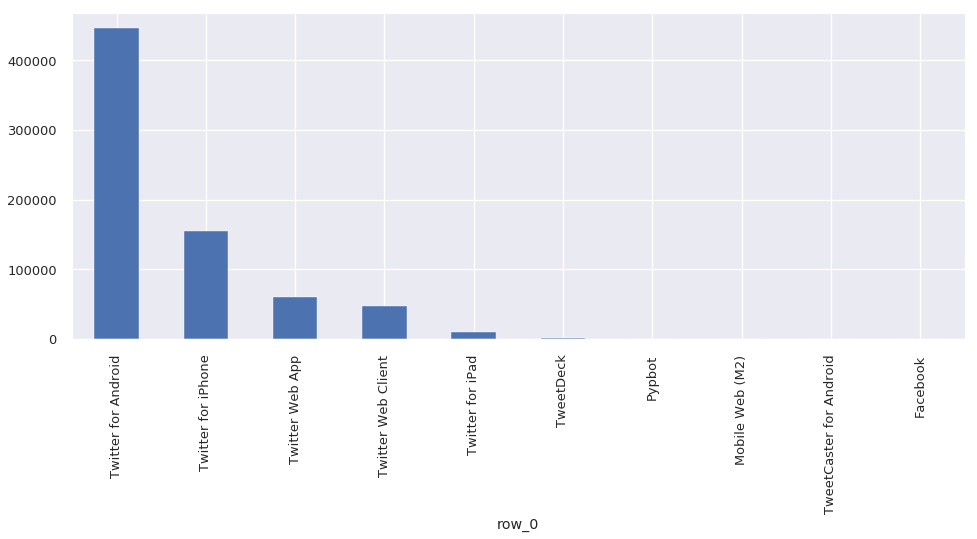

In [19]:
devices=pd.crosstab(index=np.array(tw_device), columns="count")
devices=devices.sort_values(by=['count'] , ascending=False)["count"]
devices[:10].plot(figsize=(16, 6), kind="bar")
devices[:10]

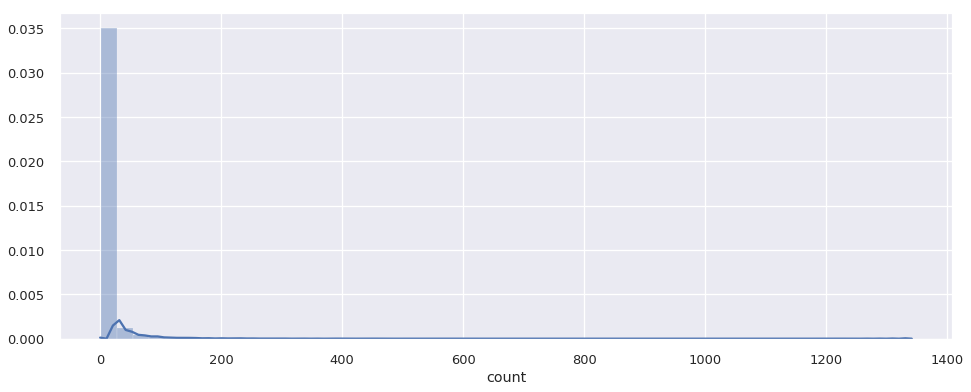

In [20]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [21]:
round(ids_freqs.describe(),3)

count    85845.000
mean         8.400
std         27.262
min          1.000
25%          1.000
50%          2.000
75%          5.000
max       1340.000
Name: count, dtype: float64

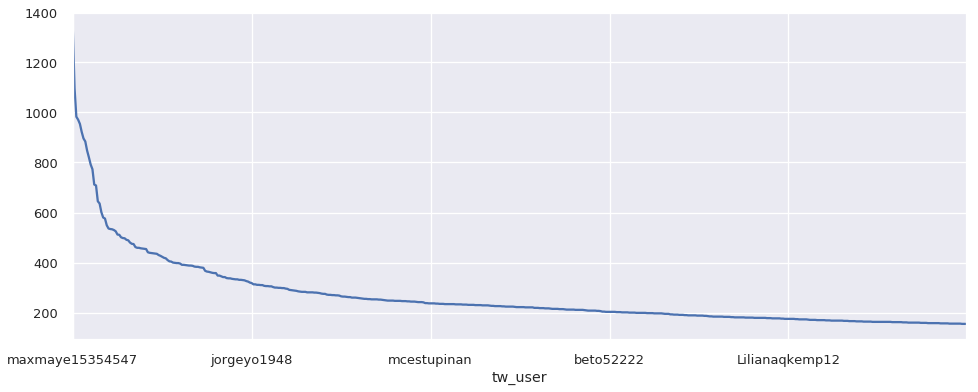

In [22]:
ids_freqs[:500].plot(figsize=(16, 6))

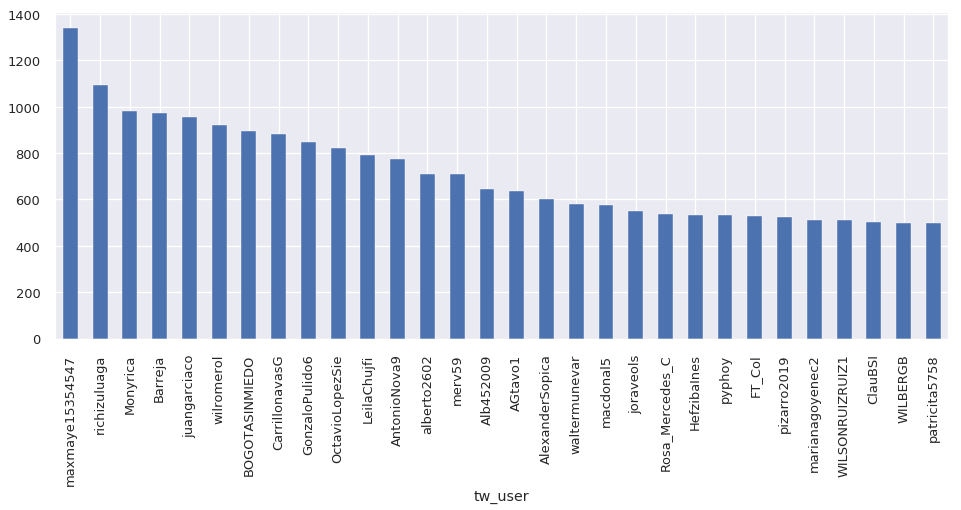

In [23]:
ids_freqs[:30].plot(figsize=(16, 6), kind="bar")
plt.savefig(drive_path+'top_tweeters.png')

In [24]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
maxmaye15354547    1340
richizuluaga       1096
Monyrica            983
Barreja             971
juangarciaco        954
wilromerol          922
BOGOTASINMIEDO      896
CarrillonavasG      884
GonzaloPulido6      848
OctavioLopezSie     821
LeilaChujfi         792
AntonioNova9        773
alberto2602         712
merv59              708
Alb452009           645
AGtavo1             636
AlexanderSopica     601
waltermunevar       580
macdonal5           576
joraveols           549
Rosa_Mercedes_C     536
HefzibaInes         534
pyphoy              533
FT_Col              530
pizarro2019         525
marianagoyenec2     512
WILSONRUIZRUIZ1     511
ClauBSI             501
WILBERGB            498
patricita5758       497
FlixSaenz2          491
elenavallejoa       489
GiordanoBrunoFi     480
neoflash5           475
cesar_garcia_nt     474
marco_caldono       462
ceciliarm1948       459
helmanzano          459
ktina_mejia         457
Aemon3428           456
edisonbedoya        455
uribista

In [25]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

33165

ClaudiaLopez       368815
petrogustavo       113424
MiguelUribeT       101467
HOLLMANMORRIS       96358
angelamrobledo      80354
angelagarzonc       65973
LuisErnestoGL       50158
EnriquePenalosa     44706
AlvaroUribeVel      35292
GustavoBolivar      34670
carlosfgalan        33443
CeDemocratico       31421
jerojasrodrigue     31099
IvanDuque           24566
GNavasTalero        20654
CelioNievesH        19741
CarlosCarrilloA     17956
DavidRacero         16149
PartidoVerdeCoL     16147
MAndreaNieto        15434
dtype: int64


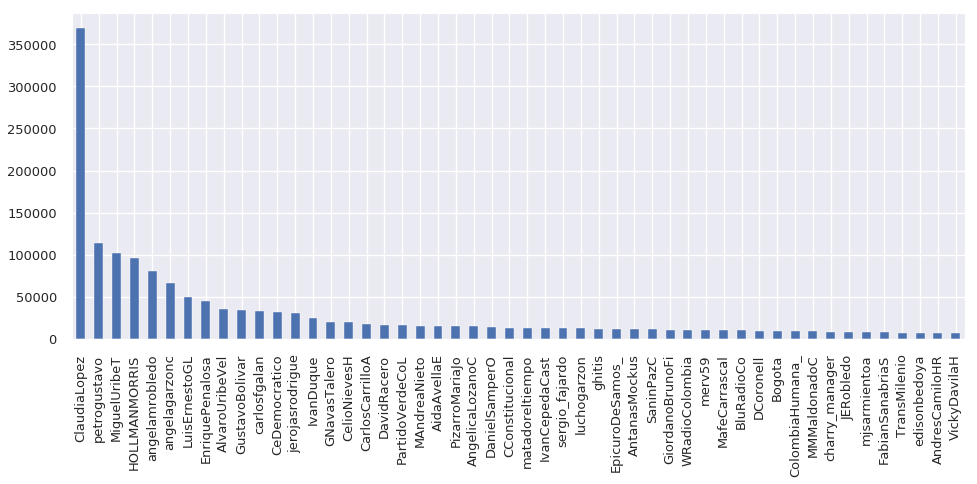

In [26]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig(drive_path+'top_mentions.png')

ClaudiaLopez       368815
MiguelUribeT       101467
hollmanmorris       96358
angelamrobledo      80354
angelagarzonc       65973
LuisErnestoGL       50158
carlosfgalan        33443
jerojasrodrigue     31099
CelioNievesH        19741
MAndreaNieto        15434
luchogarzon         12722
dtype: int64


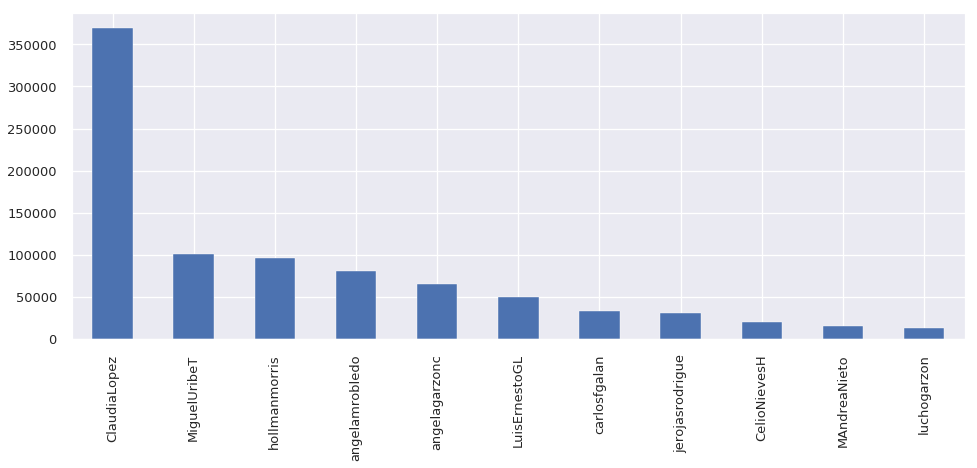

In [27]:
plt.figure(figsize=(16,6))
print (df_mntns_candts.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_candts.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig(drive_path+'df_mntns_candts.png')

# Relaciones de cuentas

In [0]:
directed_graph_df=df_mntns_top_ocurr.groupby(tw_user).aggregate(sum)
mat_dendr=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr.sample(20)

In [0]:
ments_ward= hierarchy.linkage(mat_dendr.transpose(), 'ward')

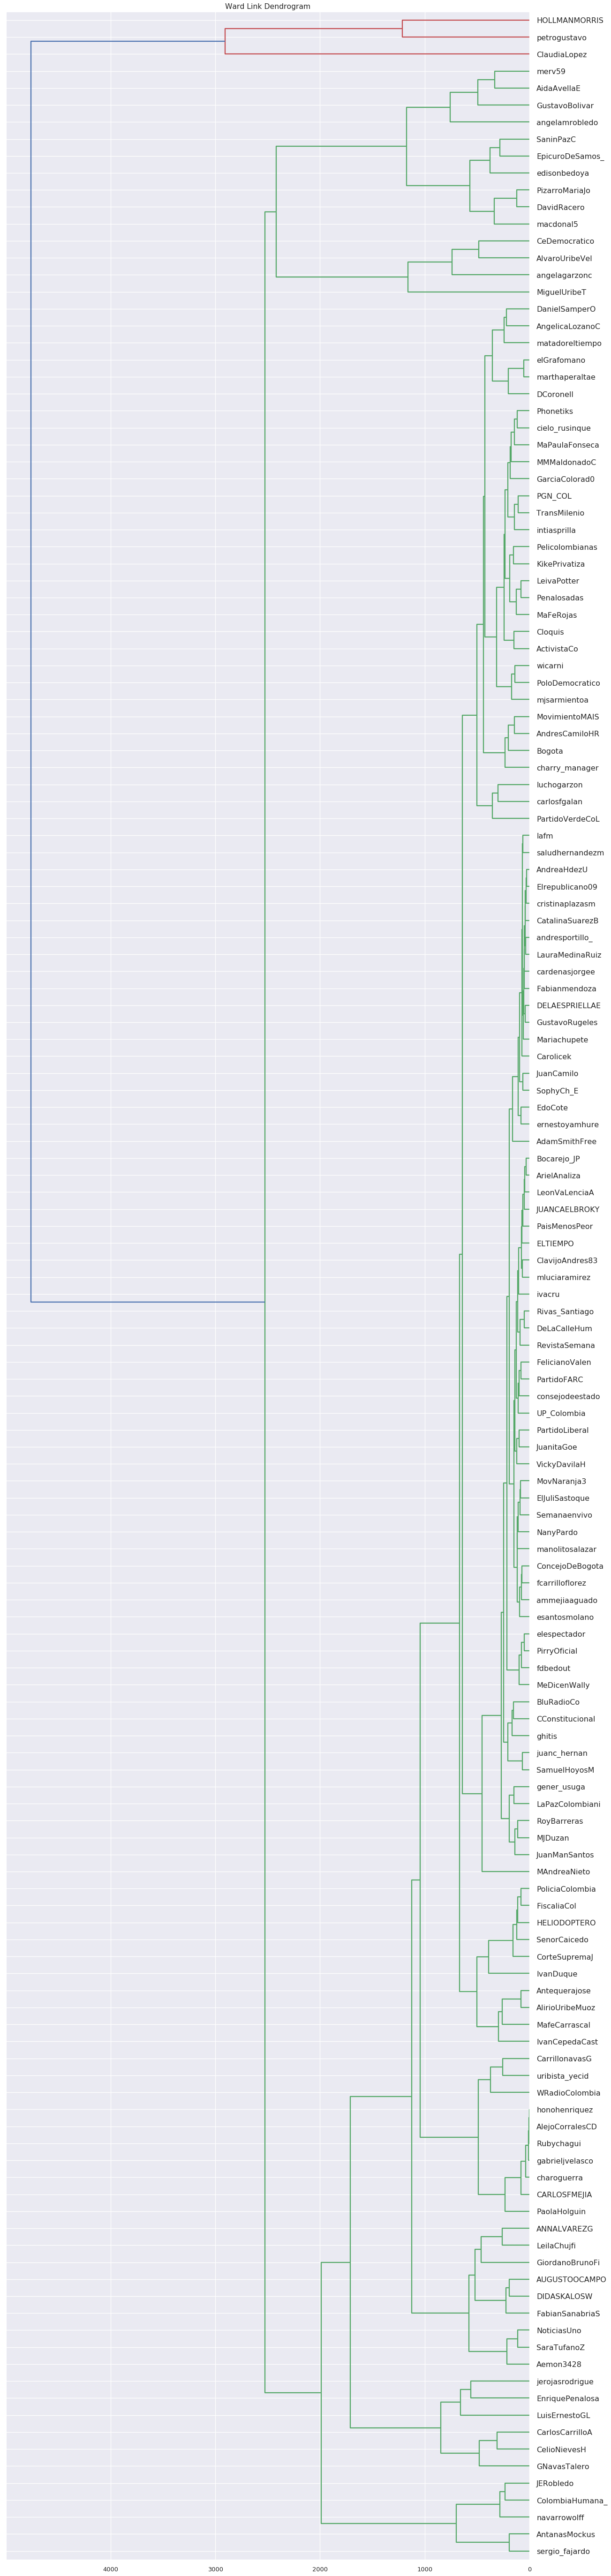

In [30]:
plt.figure(figsize=(20,100))
dn = hierarchy.dendrogram(ments_ward,orientation="left", labels=df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False).index)
plt.yticks(fontsize=16)
plt.title('Ward Link Dendrogram')
plt.savefig(drive_path+'ments_dendrograma_ward.png')
plt.show()

In [0]:
directed_graph_df_candts=df_mntns_candts.groupby(tw_user).aggregate(sum)
mat_dendr_candts=directed_graph_df_candts.loc[directed_graph_df_candts.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr_candts.sample(20)

In [0]:
cands_ward= hierarchy.linkage(mat_dendr_candts.transpose(), 'ward')

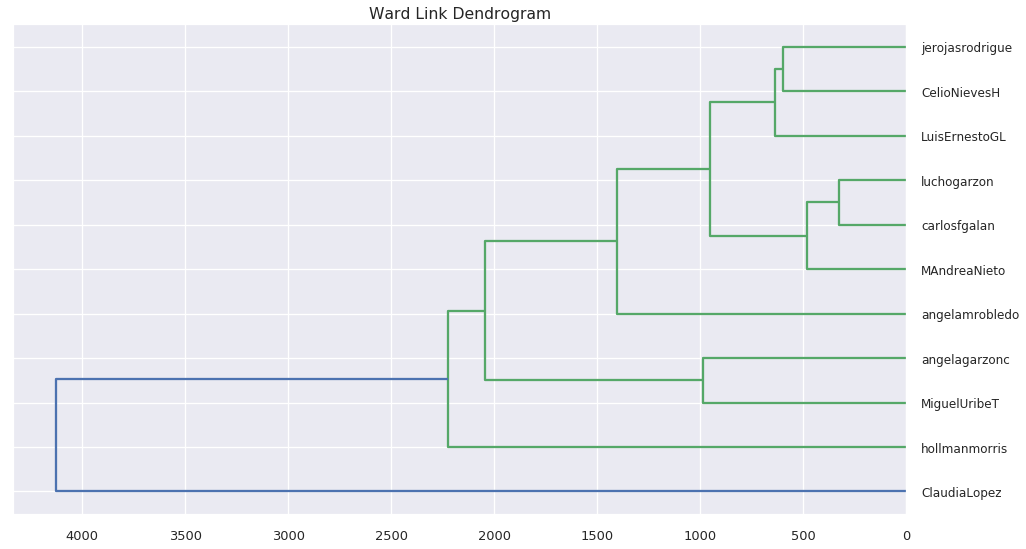

In [33]:
plt.figure(figsize=(16,9))
dn = hierarchy.dendrogram(cands_ward,orientation="left", labels=cuentas)
# plt.yticks(fontsize=16)
plt.title('Ward Link Dendrogram')
plt.savefig(drive_path+'cands_dendrograma_ward.png')
plt.show()

# Temporalidad

In [0]:
tw_fechas_df=pd.DataFrame(np.column_stack([tw_user,tw_date]))
tw_fechas_df.columns=["user","date_tweet"]
tw_fechas_df["date_tweet"]=pd.to_datetime(tw_fechas_df['date_tweet'], utc=True)#.tz_convert('US/Eastern')
tw_fechas_df.set_index('date_tweet', inplace=True)#.tz_convert('US/Eastern')
tw_fechas_df.index=tw_fechas_df.index.tz_convert('Etc/GMT+5')
tw_fechas_df["ocurr"]=1

In [0]:
time_sample="3600s"#'1440T'#"1800S"#"900S"#"3600s"#

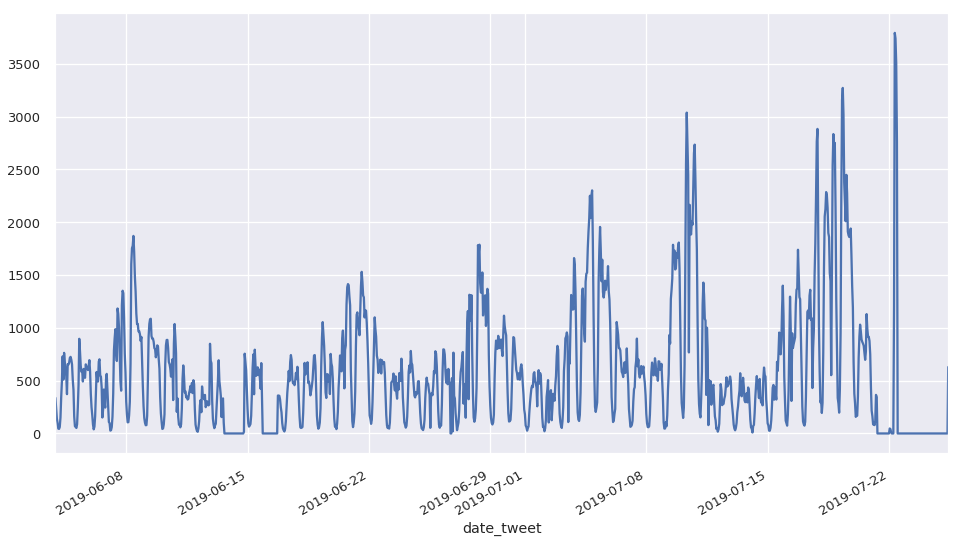

In [36]:
plt.figure(figsize=(16,9))
tw_fechas_df.ocurr.resample(time_sample).sum().plot()#kind="bar")

## Menciones

In [0]:
mayor_tweeters=list(directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:10])

In [0]:
tw_fechas_df_top=tw_fechas_df[tw_fechas_df.user.isin(mayor_tweeters)]

In [0]:
twits_filt=pd.crosstab(index=tw_fechas_df_top.index,
                  columns=tw_fechas_df_top["user"])
twits_filt=twits_filt.resample(time_sample).sum()

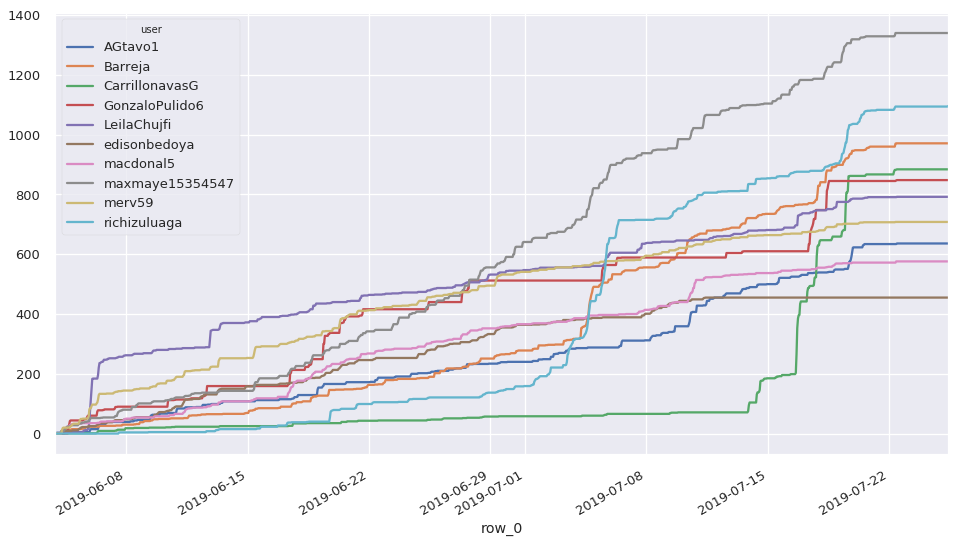

In [40]:
twits_filt.cumsum().plot(figsize=(16,9))

In [0]:
top_ments_df=df_mntns_top_ocurr.copy()*1
top_ments_df.index=tw_fechas_df.index
# top_ments_df.head(20)

In [0]:
top_ments_df_day=top_ments_df.iloc[:,:10].resample(time_sample).sum()

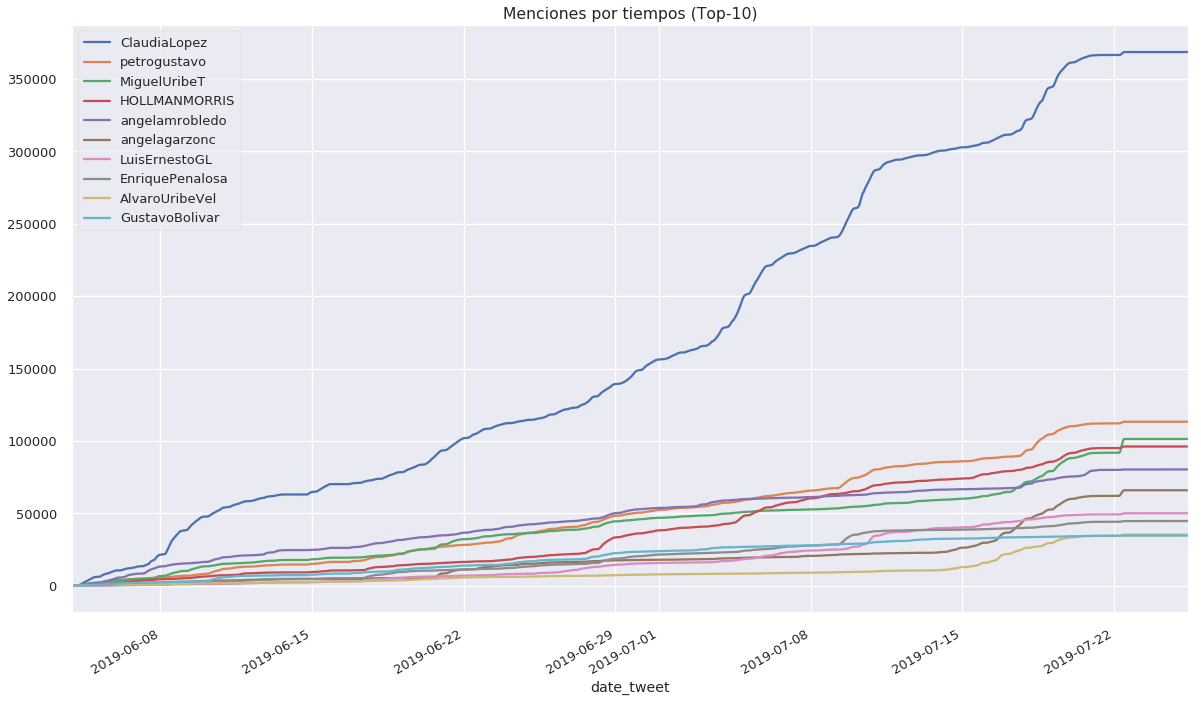

In [43]:
top_ments_df_day.cumsum().plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

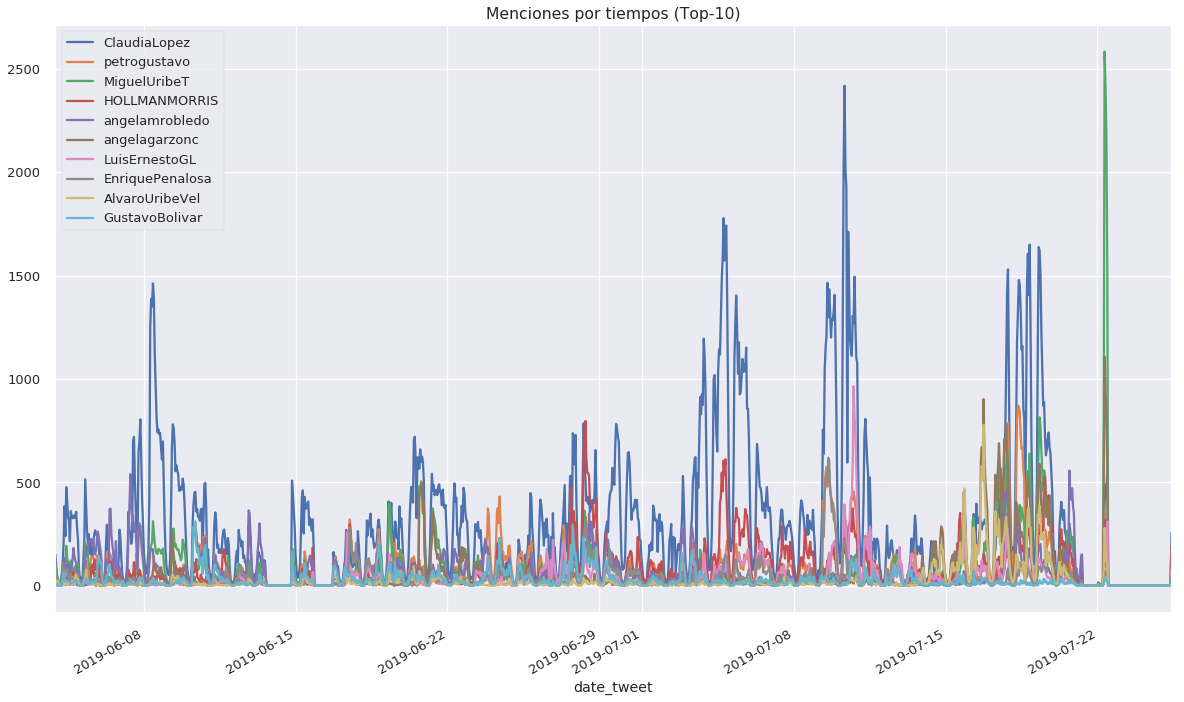

In [44]:
top_ments_df_day.plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

## Candidatos

In [0]:
tw_fechas_df_cands=tw_fechas_df[tw_fechas_df.user.isin(cuentas)]

In [0]:
twits_filt_cands=pd.crosstab(index=tw_fechas_df_cands.index,
                  columns=tw_fechas_df_cands["user"])
twits_filt_cands=twits_filt_cands.resample(time_sample).sum()

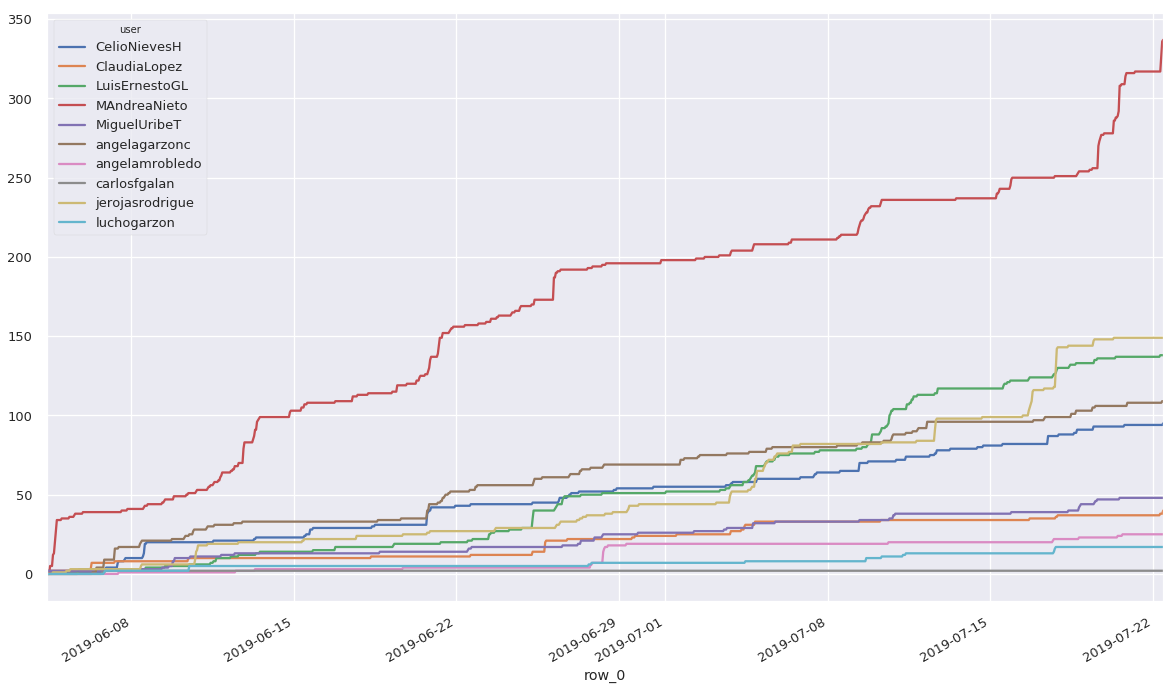

In [47]:
twits_filt_cands.cumsum().plot(figsize=(20,12))# No cuadra este gráfico # Revisar!!!!!!

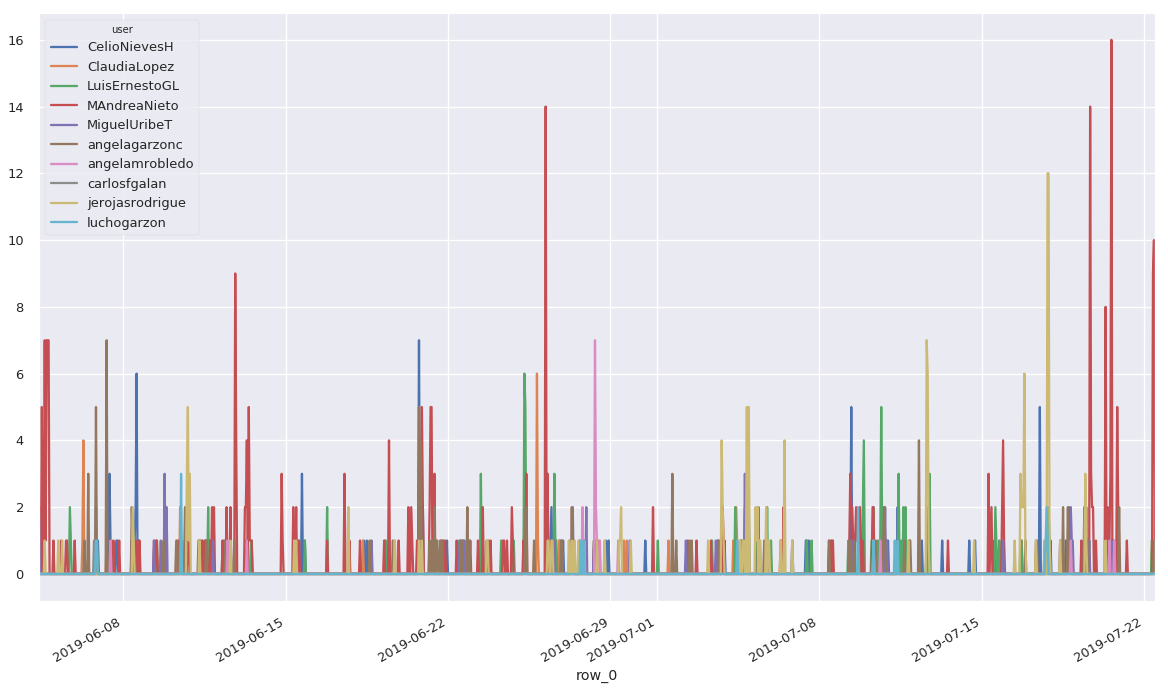

In [48]:
twits_filt_cands.plot(figsize=(20,12))# No cuadra este gráfico # Revisar!!!!!!

# Grafos

In [49]:
mat_size=40
graph_mat=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:mat_size],
                                directed_graph_df.sum(axis=0).sort_values(ascending=False).index[:mat_size]
                               ]
graph_mat.head()

,ClaudiaLopez,petrogustavo,MiguelUribeT,HOLLMANMORRIS,angelamrobledo,angelagarzonc,LuisErnestoGL,EnriquePenalosa,AlvaroUribeVel,GustavoBolivar,carlosfgalan,CeDemocratico,jerojasrodrigue,IvanDuque,GNavasTalero,CelioNievesH,CarlosCarrilloA,DavidRacero,PartidoVerdeCoL,MAndreaNieto,AidaAvellaE,PizarroMariaJo,AngelicaLozanoC,DanielSamperO,CConstitucional,matadoreltiempo,IvanCepedaCast,sergio_fajardo,luchogarzon,ghitis,EpicuroDeSamos_,AntanasMockus,SaninPazC,GiordanoBrunoFi,WRadioColombia,merv59,MafeCarrascal,BluRadioCo,DCoronell,Bogota
maxmaye15354547,569.0,220.0,74.0,429.0,45.0,23.0,168.0,154.0,7.0,68.0,54.0,2.0,88.0,7.0,468.0,503.0,424.0,24.0,82.0,5.0,12.0,19.0,17.0,20.0,1.0,13.0,24.0,11.0,45.0,0.0,11.0,9.0,38.0,137.0,10.0,22.0,17.0,10.0,5.0,24.0
merv59,99.0,412.0,10.0,40.0,497.0,3.0,5.0,4.0,131.0,403.0,4.0,30.0,15.0,62.0,29.0,15.0,4.0,314.0,25.0,0.0,404.0,329.0,30.0,37.0,0.0,79.0,68.0,23.0,8.0,0.0,164.0,6.0,183.0,92.0,3.0,571.0,21.0,1.0,35.0,1.0
LeilaChujfi,168.0,167.0,9.0,114.0,452.0,3.0,30.0,10.0,65.0,333.0,4.0,8.0,40.0,117.0,40.0,17.0,36.0,21.0,13.0,0.0,258.0,13.0,44.0,53.0,0.0,154.0,30.0,25.0,1.0,0.0,20.0,2.0,42.0,300.0,6.0,415.0,13.0,2.0,100.0,6.0
richizuluaga,782.0,268.0,30.0,242.0,37.0,6.0,46.0,31.0,21.0,11.0,27.0,1.0,49.0,1.0,6.0,21.0,98.0,1.0,39.0,25.0,0.0,9.0,16.0,1.0,0.0,8.0,0.0,431.0,13.0,4.0,5.0,398.0,46.0,195.0,1.0,1.0,0.0,3.0,14.0,46.0
Barreja,422.0,359.0,30.0,478.0,138.0,2.0,112.0,56.0,16.0,108.0,38.0,6.0,100.0,20.0,147.0,100.0,58.0,35.0,36.0,0.0,45.0,47.0,27.0,8.0,0.0,42.0,46.0,30.0,11.0,0.0,10.0,8.0,69.0,134.0,8.0,46.0,13.0,1.0,9.0,8.0


In [50]:
graph_mat.shape

(40, 40)

In [0]:
graph_df=graph_mat.melt()
graph_df.columns=["tw_para", "freq"]
graph_df["tw_de"]=[usr for i in range(int(len(graph_df)/len(graph_mat.index)))for usr in list(graph_mat.index)]
graph_df=graph_df.loc[:,["tw_de","tw_para","freq"]]

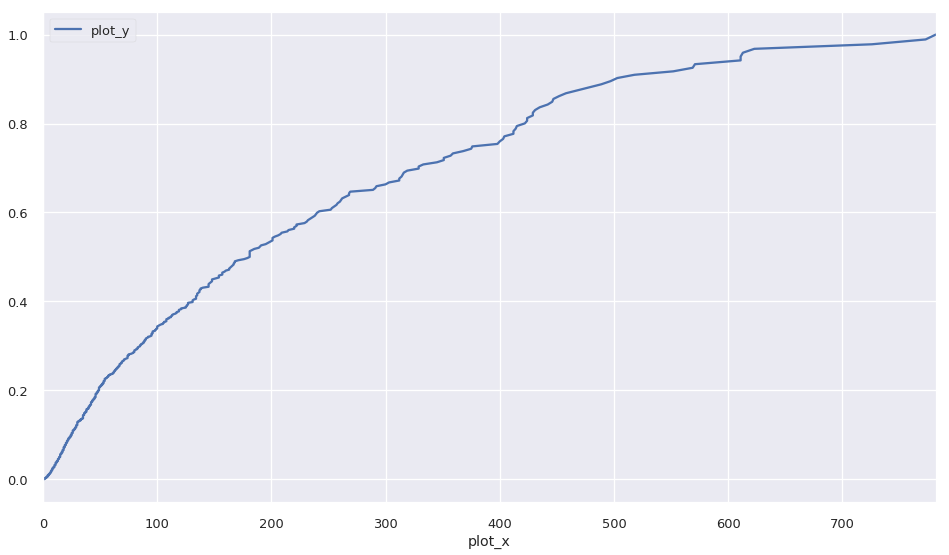

In [52]:
plot_x=np.array(list(graph_df.freq.sort_values(ascending=True)))
plot_y=np.cumsum(plot_x)/sum(plot_x)
cum_freq=pd.DataFrame({"plot_x":plot_x,
                       "plot_y":plot_y})
cum_freq.plot(x="plot_x",
              y="plot_y",
             figsize=(16,9))

In [53]:
min_crit_tw=cum_freq[cum_freq.plot_y>=.3].iloc[0,0]
graph_df_filt=graph_df.loc[graph_df.freq>=min_crit_tw,:]
mx_fr=max(graph_df_filt.freq)
print(min_crit_tw)
print(len(graph_df_filt))
graph_df_filt.sort_values("freq",ascending=False)#.head(20)

85.0
222


,tw_de,tw_para,freq
3,richizuluaga,ClaudiaLopez,782.0
206,CarrillonavasG,angelagarzonc,773.0
19,BOGOTASINMIEDO,ClaudiaLopez,726.0
8,AGtavo1,ClaudiaLopez,623.0
133,Monyrica,HOLLMANMORRIS,613.0
1248,AGtavo1,AntanasMockus,611.0
1088,AGtavo1,sergio_fajardo,611.0
1401,merv59,merv59,571.0
0,maxmaye15354547,ClaudiaLopez,569.0
29,AntonioNova9,ClaudiaLopez,552.0


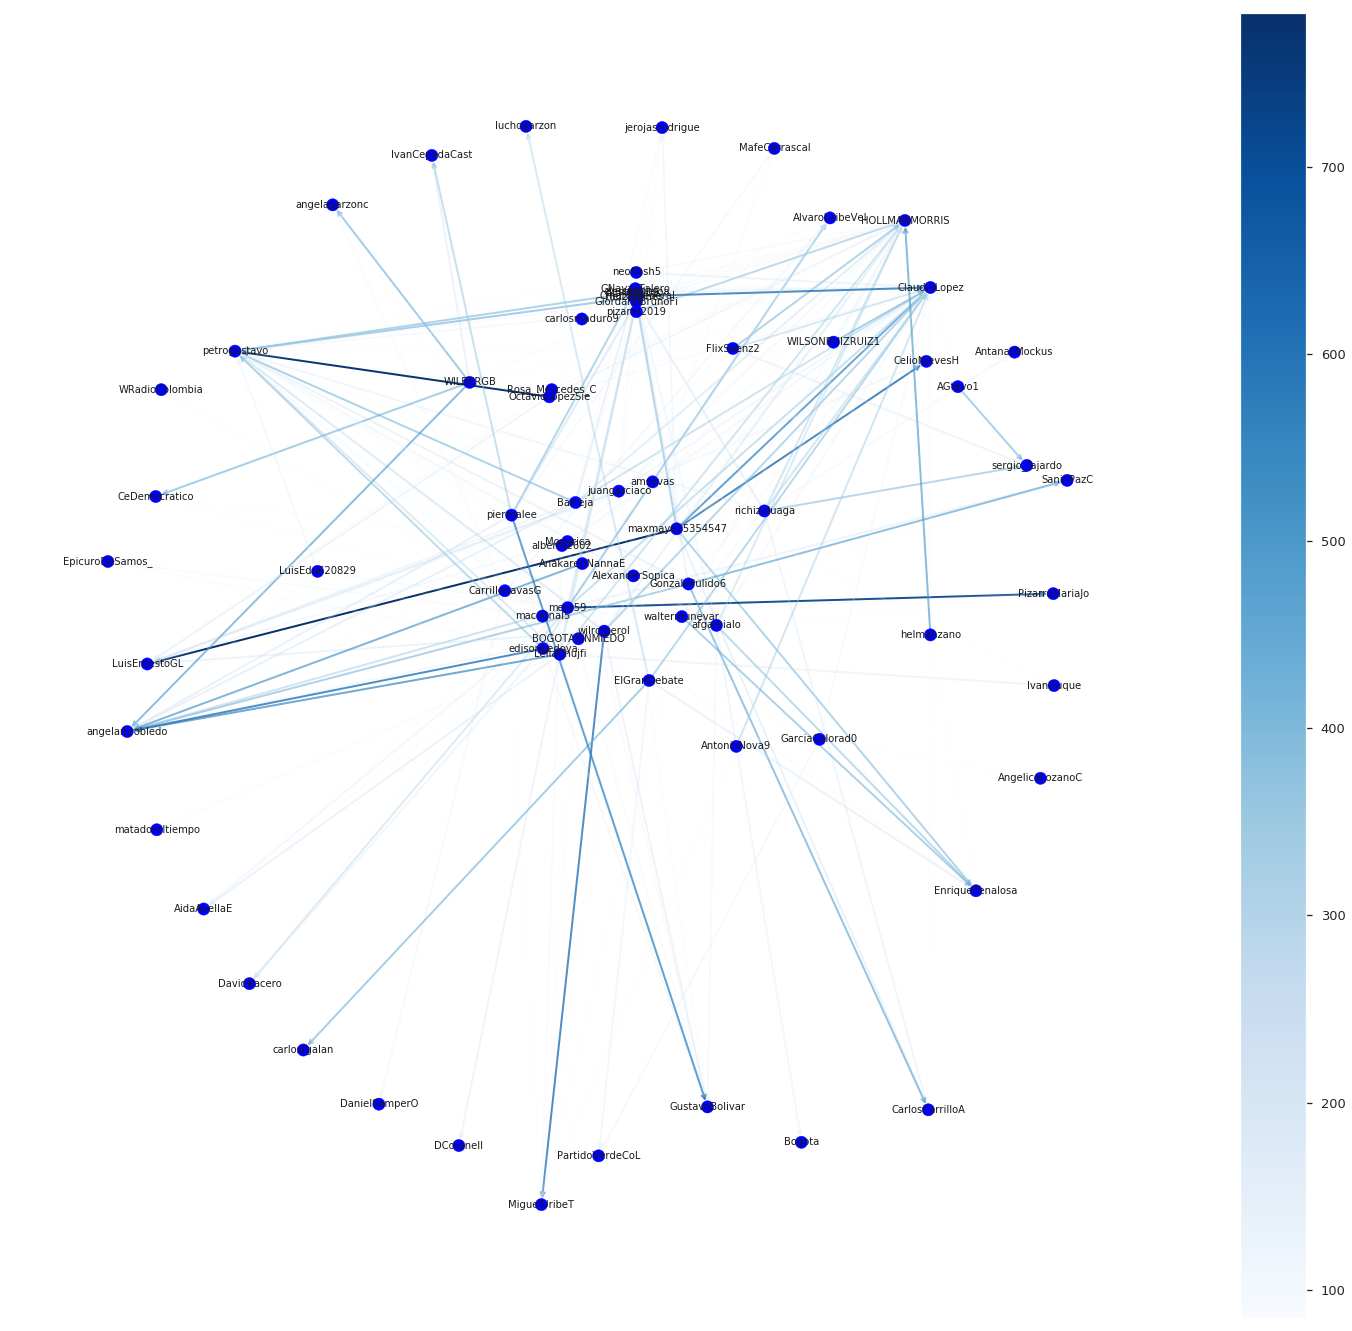

In [54]:
plt.figure(figsize=(26,24))
G= nx.DiGraph()#nx.generators.directed.random_k_out_graph(10, 3, 0.5)
for i, elrow in graph_df_filt.iterrows():
    G.add_edge(elrow[0], elrow[1])

pos = nx.layout.spring_layout(G)

node_sizes = [150 for i in range(len(G))]
M = G.number_of_edges()
edge_colors =[fr for fr in graph_df_filt.freq]#range(2, M + 2)
edge_alphas =[fr/mx_fr for fr in graph_df_filt.freq]#[fr/mx_fr for fr in graph_df_filt.freq]#[(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

nx.draw_networkx_labels(G, pos, font_size=10)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [0]:
g = nx.Graph()


In [0]:
for i, elrow in graph_df_filt.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [57]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 222
# of nodes: 73


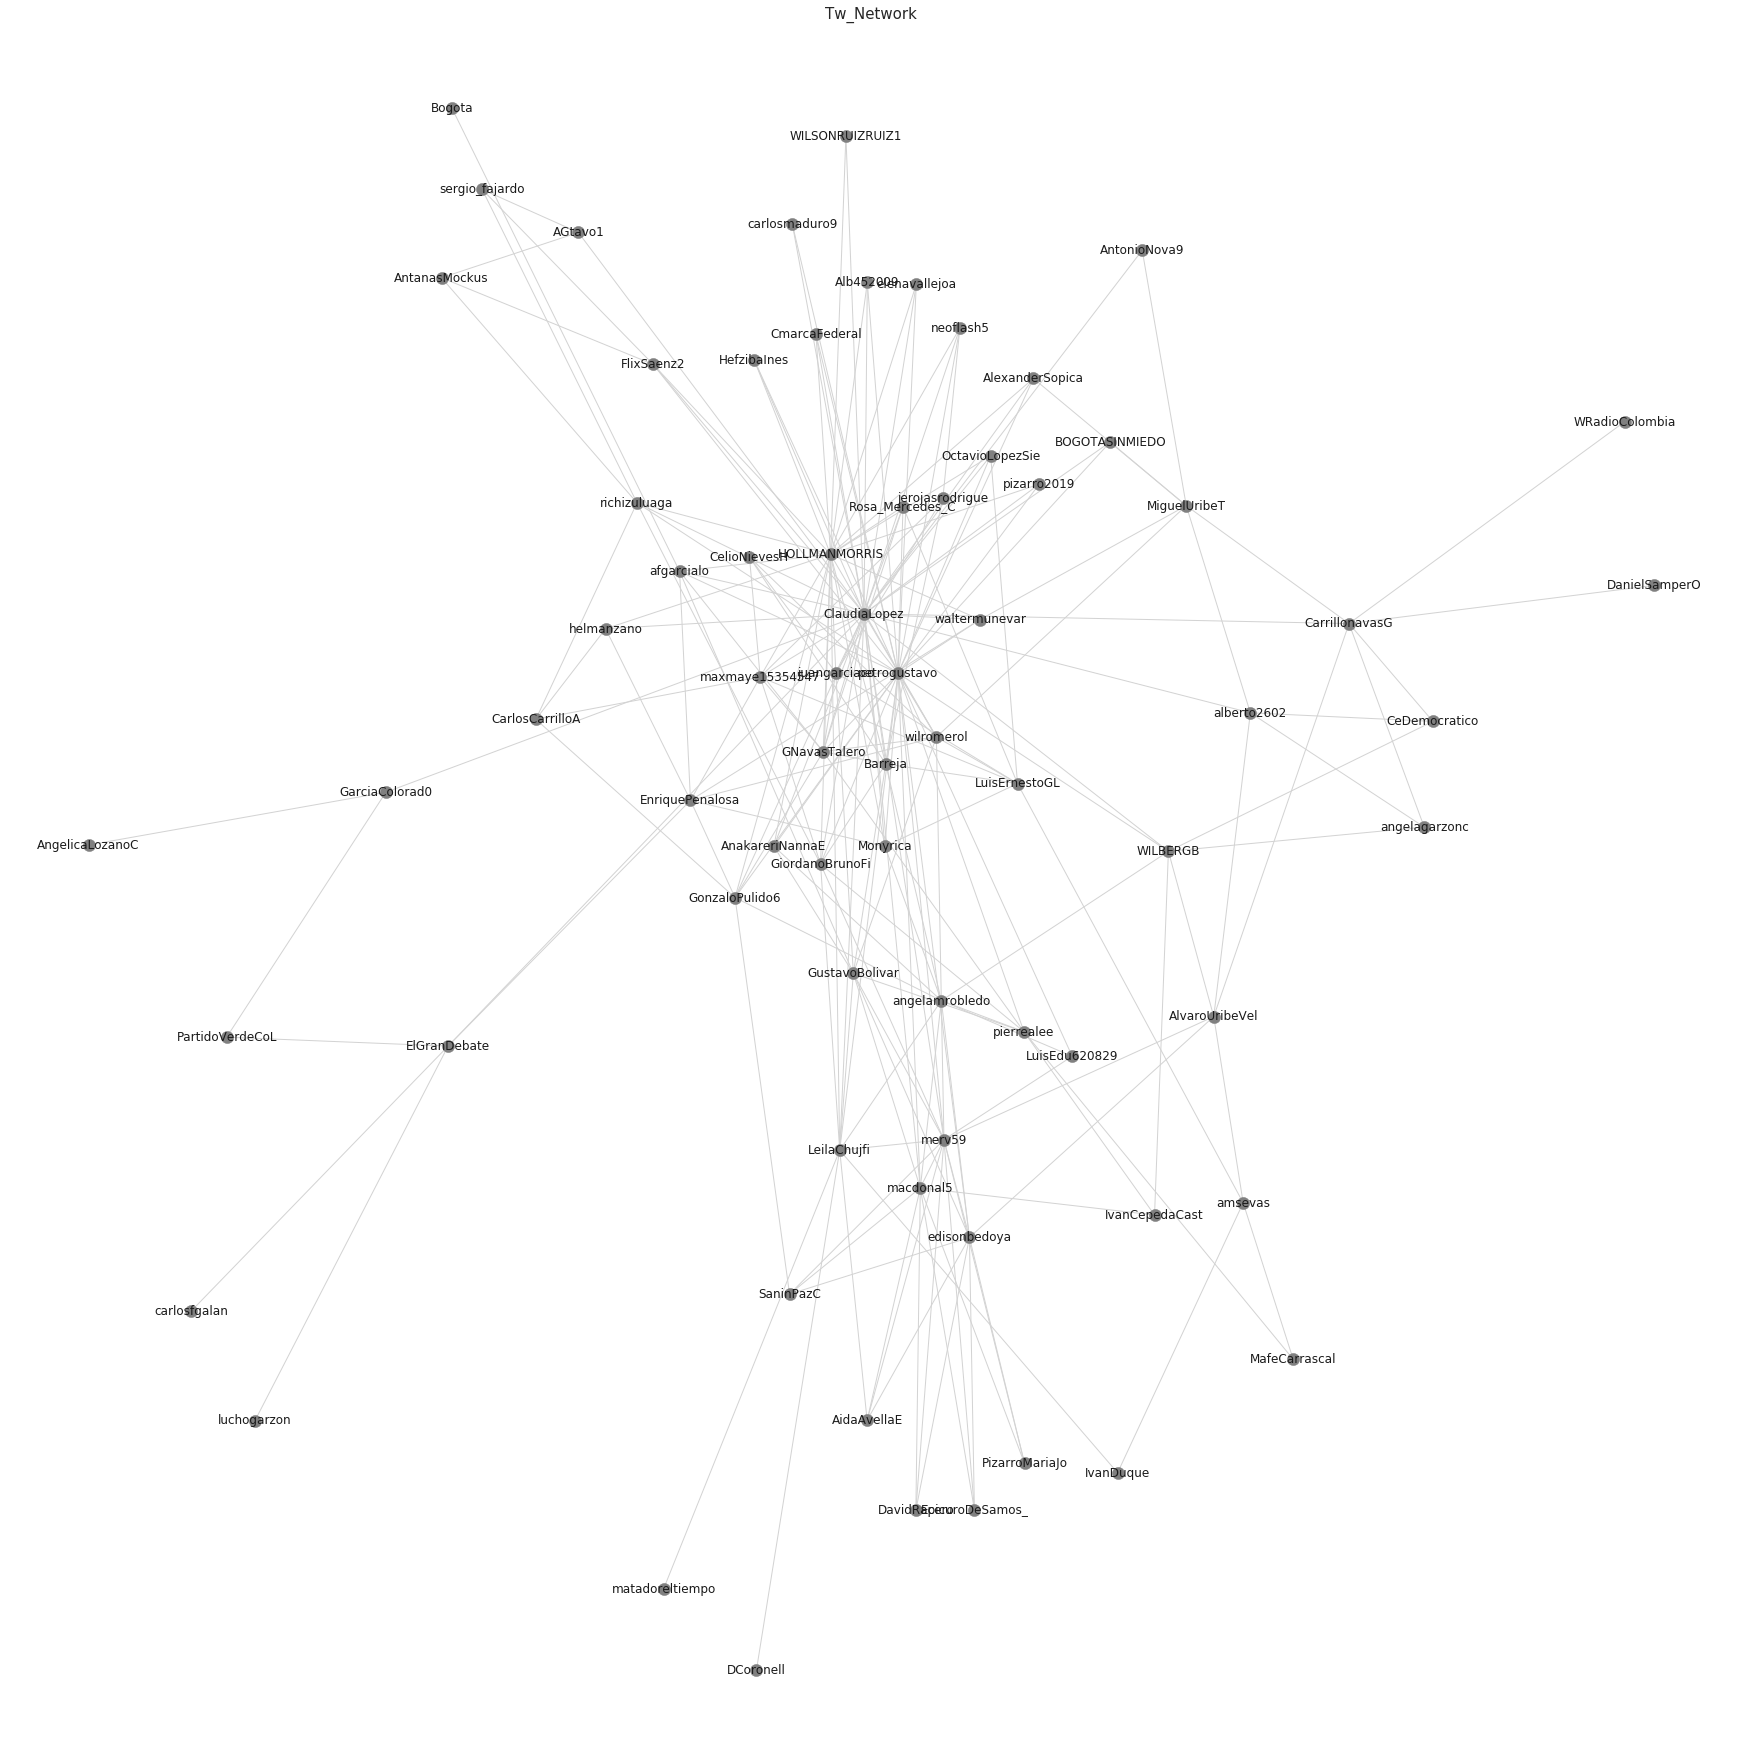

In [58]:
plt.figure(figsize=(24, 24))
nx.draw(g,
        node_size=150,
        edge_color='lightgray',
        node_color='gray',
        with_labels=True)
plt.title('Tw_Network', size=15)
plt.show()
# plt.savefig('tweets_net.png')